In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [2]:
import os
import torch
from torchvision import transforms, datasets, models
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

Preprocess and Augumentation

In [3]:
# Definizione dei percorsi delle cartelle di training, validation e test
# Supponendo che la struttura del dataset in Kaggle sia già organizzata

train_dir = '/kaggle/input/dstoprocess/dsToProcess/train/'
val_dir = '/kaggle/input/dstoprocess/dsToProcess/val/'
test_dir = '/kaggle/input/dstoprocess/dsToProcess/test/'


# Ambiente su cui fare running
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Run on GPU')
else:
    device = torch.device("cpu")
    print('Run on CPU')

# Data PreProcessing e Augmentation
image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Datasets per ogni categoria
data = {
    'train': datasets.ImageFolder(root=train_dir, transform=image_transforms['train']),
    'val': datasets.ImageFolder(root=val_dir, transform=image_transforms['val']),
    'test': datasets.ImageFolder(root=test_dir, transform=image_transforms['test'])
}

# Dataloader iterators
batch_size = 32
train_loader = DataLoader(data['train'], batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(data['val'], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(data['test'], batch_size=batch_size, shuffle=True)

print(train_loader.dataset.classes, len(train_loader.dataset.classes))
print(valid_loader.dataset.classes, len(valid_loader.dataset.classes))
print(test_loader.dataset.classes, len(test_loader.dataset.classes))

Run on GPU
['bacon', 'banana', 'bread', 'broccoli', 'butter', 'carrots', 'cheese', 'chicken', 'cucumber', 'eggs', 'fish', 'lettuce', 'milk', 'onions', 'peppers', 'potatoes', 'sausages', 'spinach', 'tomato', 'yogurt'] 20
['bacon', 'banana', 'bread', 'broccoli', 'butter', 'carrots', 'cheese', 'chicken', 'cucumber', 'eggs', 'fish', 'lettuce', 'milk', 'onions', 'peppers', 'potatoes', 'sausages', 'spinach', 'tomato', 'yogurt'] 20
['bacon', 'banana', 'bread', 'broccoli', 'butter', 'carrots', 'cheese', 'chicken', 'cucumber', 'eggs', 'fish', 'lettuce', 'milk', 'onions', 'peppers', 'potatoes', 'sausages', 'spinach', 'tomato', 'yogurt'] 20


Definizione del modello

In [4]:
# Definisci il dispositivo: usa la GPU se disponibile, altrimenti la CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Percorso al file dei pesi scaricati
weights_path = '/kaggle/input/pesiresnet/resnet50-0676ba61.pth'  # Sostituisci "your-folder-name" con il nome effettivo della tua cartella
from torchvision.models import resnet50
# Carica il modello ResNet50 senza pesi
model = resnet50(weights=None)

# Carica i pesi salvati nel file
state_dict = torch.load(weights_path, map_location=device)
model.load_state_dict(state_dict)

# Modifica il layer finale per il numero specifico di classi
n_classes = len(train_loader.dataset.classes)  # Assicurati che train_loader sia definito correttamente
# Aggiungi un layer di dropout prima del layer finale
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),  # Dropout con probabilità 0.6
    nn.Linear(model.fc.in_features, n_classes)
)

# Congela i pesi di tutte le layer
for param in model.parameters():
    param.requires_grad = False

# Sblocca i pesi dell'ultimo blocco di ResNet (ad esempio, layer4)
for name, param in model.named_parameters():
    if "layer4" in name:
        param.requires_grad = True

# Sblocca i pesi del layer finale completamente connesso
for param in model.fc.parameters():
    param.requires_grad = True

# Muovi il modello sul dispositivo corretto
model = model.to(device)


In [5]:
criterion = nn.CrossEntropyLoss()

# Definisci l'ottimizzatore con differenziazione dei learning rate
optimizer = torch.optim.Adam([
    {'params': model.layer4.parameters(), 'lr': 1e-5},  # Learning rate minore per i layer sbloccati
    {'params': model.fc.parameters(), 'lr': 1e-4}  # Learning rate maggiore per il layer finale
], weight_decay=1e-4)

# Imposta il MinLR desiderato (ad esempio, 1e-7)
min_lr = 1e-6

# Definisci lo scheduler per ridurre il learning rate in base alla validation loss con una pazienza di 3
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=3, verbose=True, min_lr=min_lr
)

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train function

In [6]:
# Funzione di addestramento
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_samples
    return avg_loss, accuracy


Validation function

In [7]:

# Funzione di validazione
def validate(model, valid_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / len(valid_loader)
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

Ciclo di allenamento

In [8]:
# Inizializza le liste per tenere traccia di loss e accuracy per ogni epoca
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Main training loop
num_epochs = 50
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, valid_loader, criterion, device)
    
    
    # Aggiorna lo scheduler basandosi sulla validation loss
    scheduler.step(val_loss)
    
    # Stampa manualmente il learning rate corrente
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Current Learning Rate: {current_lr}')
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

# Salva il modello addestrato
torch.save(model.state_dict(), "resnet50model.pth")

# Avvia il download automatico (specifico per Kaggle)
from IPython.display import FileLink

# Genera un link per scaricare il file
display(FileLink('resnet50model.pth'))

Epoch 1/50
Current Learning Rate: 1e-05
Train Loss: 2.0077, Train Accuracy: 0.4542
Validation Loss: 1.4533, Validation Accuracy: 0.5896
Epoch 2/50
Current Learning Rate: 1e-05
Train Loss: 1.0853, Train Accuracy: 0.6934
Validation Loss: 1.1928, Validation Accuracy: 0.6498
Epoch 3/50
Current Learning Rate: 1e-05
Train Loss: 0.8557, Train Accuracy: 0.7481
Validation Loss: 1.0655, Validation Accuracy: 0.6848
Epoch 4/50
Current Learning Rate: 1e-05
Train Loss: 0.7184, Train Accuracy: 0.7891
Validation Loss: 1.0375, Validation Accuracy: 0.6888
Epoch 5/50
Current Learning Rate: 1e-05
Train Loss: 0.6299, Train Accuracy: 0.8121
Validation Loss: 0.9876, Validation Accuracy: 0.7150
Epoch 6/50
Current Learning Rate: 1e-05
Train Loss: 0.5668, Train Accuracy: 0.8275
Validation Loss: 0.9700, Validation Accuracy: 0.7276
Epoch 7/50
Current Learning Rate: 1e-05
Train Loss: 0.5134, Train Accuracy: 0.8440
Validation Loss: 0.9600, Validation Accuracy: 0.7350
Epoch 8/50
Current Learning Rate: 1e-05
Train Lo

/kaggle/working/resnet50model.pth

Stampo risultati

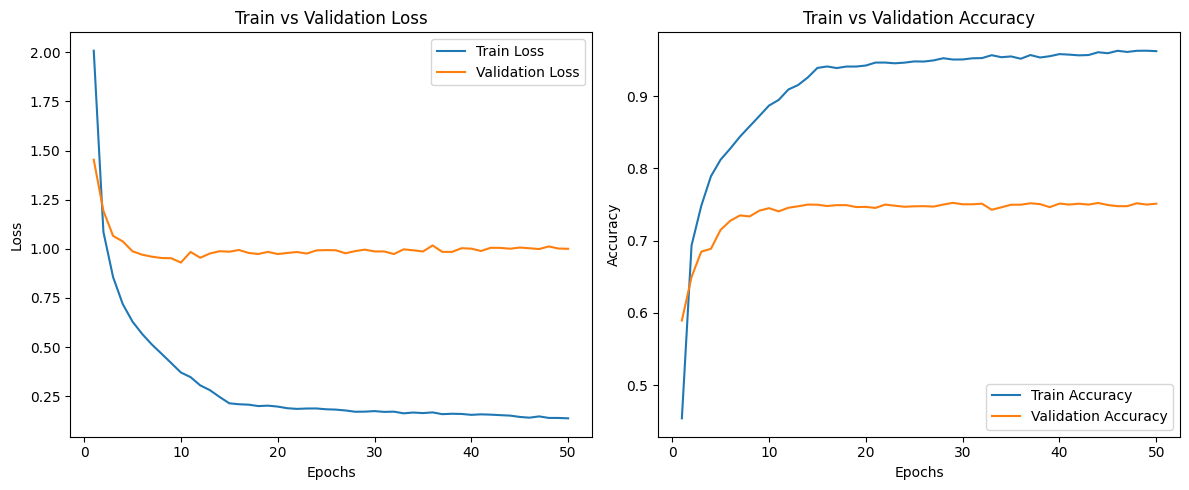

In [9]:
# Grafici di Loss e Accuracy
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Disegno la matrice di confusione

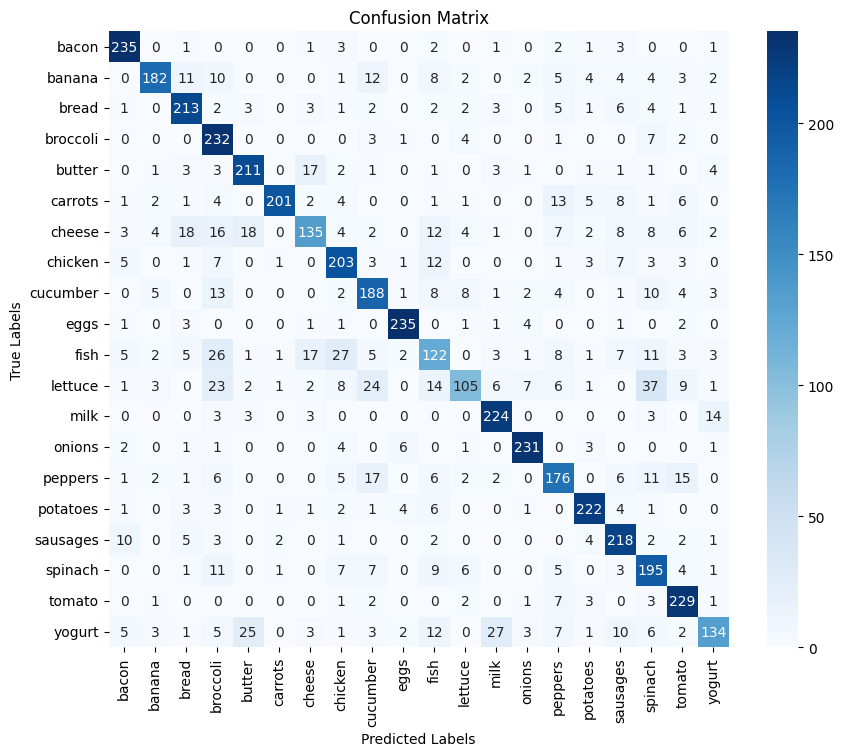

In [10]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Metti il modello in modalità di valutazione (evaluation mode)
model.eval()

# Liste per memorizzare le etichette vere e quelle predette
all_labels = []
all_preds = []

# Disattiva il calcolo del gradiente durante la valutazione
with torch.no_grad():
    for images, labels in test_loader:
        # Muovi immagini e etichette al dispositivo (GPU o CPU)
        images = images.to(device)
        labels = labels.to(device)
        
        # Ottieni le predizioni dal modello
        outputs = model(images)
        
        # Calcola le predizioni prendendo il valore massimo lungo la dimensione delle classi
        _, preds = torch.max(outputs, 1)
        
        # Aggiungi le etichette e le predizioni alle liste
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Calcola la matrice di confusione
cm = confusion_matrix(all_labels, all_preds)

# Visualizza la matrice di confusione con una heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_loader.dataset.classes, yticklabels=test_loader.dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
